最終課題用のノートブックのなかに、犬と猫の画像を学習したモデルを作成して、分類を行なうプログラムを作成してください。

本レッスン内容で学習した流れに沿って、深層学習プログラムを作成してください
データの前処理や水増しの処理を入れてください
MobileNetV2 のモデルを利用してください（画像サイズは MobileNetV2 が対応する大きさへのリサイズが必要です）
必ず最後に evaluate() を実行して、正答率がわかるようにしてください。

In [1]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横96pxにリサイズする）
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/train",
    image_size=(96, 96),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/test",
    image_size=(96, 96),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [2]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

2025-08-08 15:27:59.971687: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[[251.       , 255.       , 250.       ],
          [253.01562  , 255.       , 250.       ],
          [251.28125  , 253.1875   , 247.28125  ],
          ...,
          [254.09375  , 254.09375  , 255.       ],
          [255.       , 255.       , 255.       ],
          [255.       , 255.       , 255.       ]],
 
         [[248.3125   , 242.23438  , 244.625    ],
          [244.91113  , 239.9773   , 242.81934  ],
          [246.62012  , 242.84692  , 246.22095  ],
          ...,
          [233.927    , 234.59888  , 231.53687  ],
          [230.38208  , 231.05396  , 227.69458  ],
          [228.125    , 228.79688  , 225.4375   ]],
 
         [[193.98438  , 179.8125   , 162.25     ],
          [194.02637  , 184.06421  , 169.00024  ],
          [212.50464  , 205.66748  , 193.75659  ],
          ...,
          [143.04663  , 143.5935   , 137.23413  ],
          [134.25513  , 134.802    , 128.44263  ],
          [127.546875 , 128.09375  , 121.734375 ]],
 
         ...,
 
         [[2

In [3]:
# 分類名（cat/dog）をリストとして格納する
class_names = train_dataset.class_names
class_names

['cat', 'dog']

2025-08-08 15:28:00.052339: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


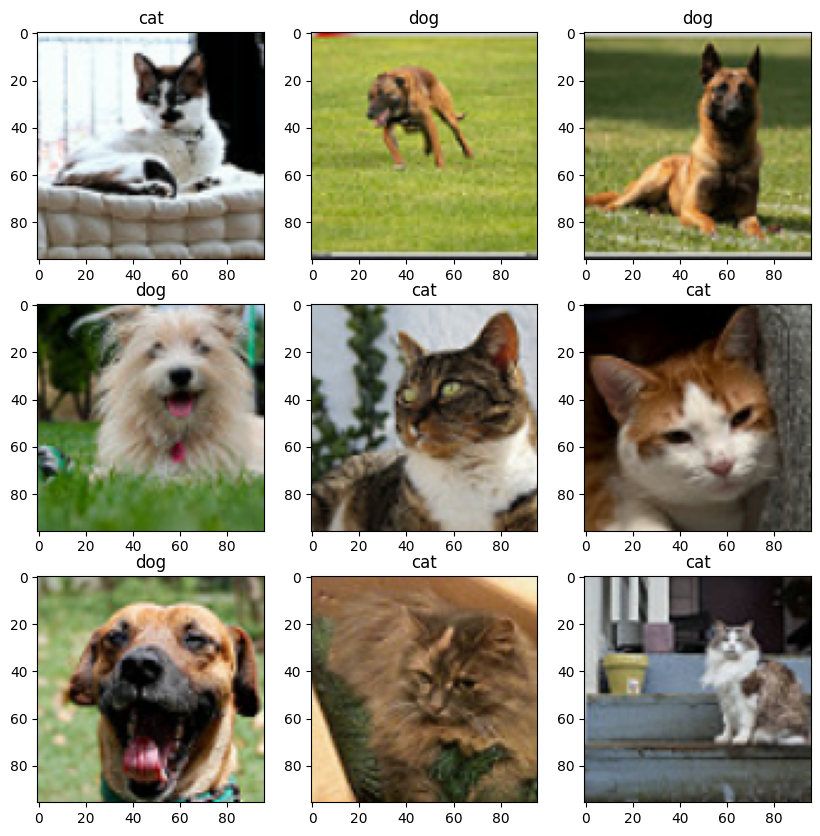

In [4]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

In [5]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

In [6]:
# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

In [7]:
# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

In [8]:
# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

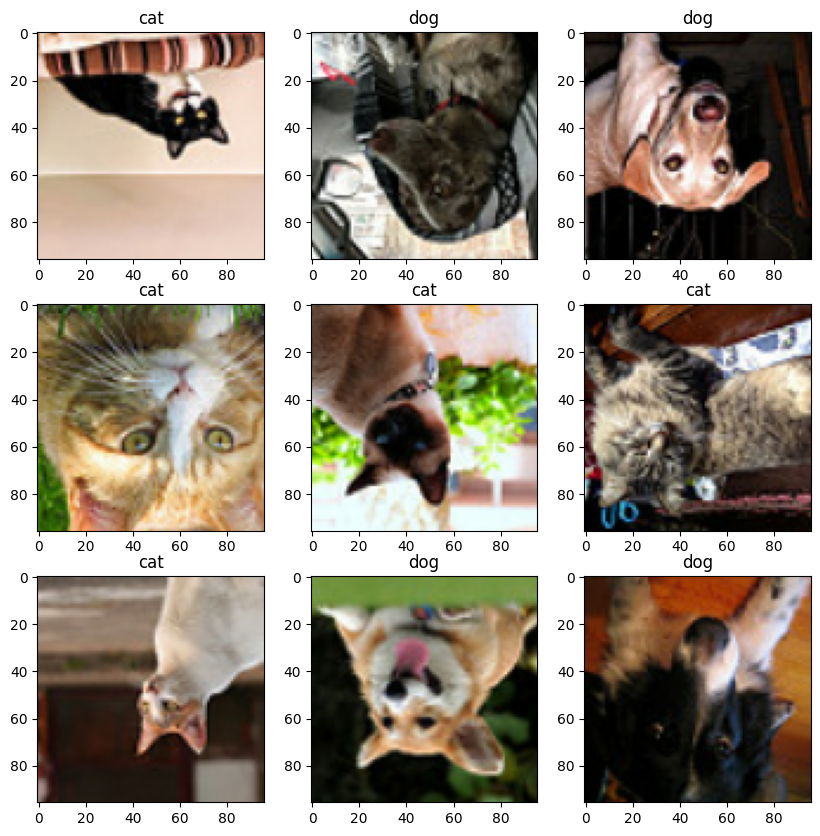

In [9]:
# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

In [10]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(96, 96, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(96, 96, 3),
    input_tensor=l_layer,
    include_top=False,
    weights="imagenet",
#    weights="./mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_96_no_top.h5",
    pooling='avg'
)
base_model.trainable = False

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_96_no_top.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1010)

In [ ]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [ ]:
# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

In [ ]:
# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [ ]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8378 - loss: 0.3616
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9417 - loss: 0.1693
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9628 - loss: 0.1252
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9761 - loss: 0.0985
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9794 - loss: 0.0803
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9833 - loss: 0.0684
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9889 - loss: 0.0588
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9928 - loss: 0.0515
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9928 - loss: 0.0440
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9978 - loss: 0.0387
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9989 - loss: 0.0343
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy:

In [ ]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


In [ ]:
# 分類した結果を確認する
pred_data

array([[6.52005943e-03],
       [3.49214912e-04],
       [6.91344903e-05],
       [5.08448575e-05],
       [3.41017358e-03],
       [5.62501326e-03],
       [6.31698349e-05],
       [2.38393876e-03],
       [2.85220402e-03],
       [5.58707165e-04],
       [3.58272286e-04],
       [2.47263089e-02],
       [4.27204126e-04],
       [1.87080994e-01],
       [6.84514933e-04],
       [7.54284789e-04],
       [2.10481972e-01],
       [1.90311240e-03],
       [1.82181800e-04],
       [2.52805185e-04],
       [2.05711010e-04],
       [3.75163509e-03],
       [7.90798804e-05],
       [2.70669785e-04],
       [8.13835442e-01],
       [1.95546905e-04],
       [5.68989012e-03],
       [1.04707215e-04],
       [4.06776100e-01],
       [2.21484806e-03],
       [1.00231599e-02],
       [4.85441864e-01],
       [1.59122249e-06],
       [2.28224933e-04],
       [2.66715535e-03],
       [4.68509048e-01],
       [1.25491008e-01],
       [5.10092068e-05],
       [1.07876176e-03],
       [2.91980745e-04],


In [ ]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9900 - loss: 0.0469


[0.04692261293530464, 0.9900000095367432]